In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_curve, confusion_matrix

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from numpy.linalg import LinAlgError

In [2]:
filename_x = './input_data/input_training_IrTAw7w.csv'
filename_y = './input_data/output_training_F2dZW38.csv'

df = pd.read_csv(filename_x).iloc[:, 1:]
Y = pd.read_csv(filename_y).iloc[:, 1:]

Y = np.argmax(np.array(Y), axis=1)

In [10]:
def predict_future_sentiment(x):
    x = np.array(x)[::-1]
    global counter 
    counter += 1
    try:
        model = ARIMA(x, (1,1,0)).fit()
    except ValueError as e:
        model = ARIMA(x, (1,2,0)).fit()
    
    if counter % 1000 == 0:
        print(counter)
    
    return model.forecast(1)[0][0]

def transform(df):
    '''
    add max, min, median, mean, trend, if_has_outlier features to sentiment data
    '''
    sentiment = get_mean_max_min_median_trend_sentiment(df)
    # Concatenate X1-X5 with sentiment feature
    df = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)
    return df

def get_trend_of_ts(ts):
    '''
    get the slope of time series, if the slope is not significant, set it to 0
    
    input:
    -----------------
    ts: time series data
    
    
    output:
    -----------------
    trend[float] (slope)
    '''
    x = np.arange(0, len(ts))
    x = sm.add_constant(x)
    model = sm.OLS(ts, x).fit()
    if model.pvalues['x1'] < 0.05:
        return model.params['x1']
    else:
        return 0
    

def get_mean_max_min_median_trend_sentiment(df):
    '''
    get the max value, min value, median value, trend value of all sentiment
    
    input:
    -------------------------------
    df[DataFrame]: input data containing sentiment data
    
    
    output:
    -------------------------------
    max value, min value, median value, trend value of all sentiment
    
    '''
    output = pd.DataFrame()
    sentiment = df.loc[:, 'I1_lag0':'I10_lag47']
    for i in tqdm(range(1, 11)):
        col_name = "I{}".format(str(i))
        start, end = col_name + "_lag0", col_name + "_lag47"
        theme_data = sentiment.loc[:, start:end]
        output[col_name+"_max"] = theme_data.max(axis=1)
        output[col_name+"_min"] = theme_data.min(axis=1)
        output[col_name+"_mean"] = theme_data.mean(axis=1)
        output[col_name+"_median"] = theme_data.median(axis=1)
        output[col_name+"_trend"] = theme_data.apply(get_trend_of_ts, axis=1)
        output[col_name+"_has_outlier"] = (theme_data.std(axis=1) > 2*overall_std).astype(int)
    
    return output

### Transformation

In [41]:
# Get the max, min, median, mean and trend of sentiment
if not os.path.exists("./temp_data/transformed_data.csv"):
    counter = 0

    overall_std = np.array(df.loc[:, "I1_lag0":"I10_lag47"]).flatten().std()

    sentiment = get_mean_max_min_median_trend_sentiment(df)
    # Concatenate X1-X5 with sentiment feature
    train = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)

    train["I9_future"] = df.loc[:,"I9_lag0":"I9_lag47"].apply(predict_future_sentiment, axis=1)


    train.to_csv('./temp_data/transformed_data.csv', index=False)
else:
    train = pd.read_csv("./temp_data/transformed_data.csv")
# split data into trainning data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(train, Y,  
                                                      test_size=0.4)

In [13]:
# Read test file
if not os.path.exists("./temp_data/transformed_test.csv"):
    counter = 0
    
    test_filename = './input_data/input_test_PkjtqdQ.csv'
    df_test = pd.read_csv(test_filename).iloc[:, 1:]

    # Get the max, min, median, mean and trend of sentiment
    sentiment_test = get_mean_max_min_median_trend_sentiment(df_test)
    test = pd.concat([df_test.loc[:, 'X1':"X5"], sentiment_test], axis=1)
    test["I9_future"] = df_test.loc[:,"I9_lag0":"I9_lag47"].apply(predict_future_sentiment, axis=1)
    
    test.to_csv('./temp_data/transformed_test.csv', index=False)
else:
    test = pd.read_csv("./temp_data/transformed_test.csv")

100%|██████████████████████████████████████████| 10/10 [00:33<00:00,  3.32s/it]
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning

1000


C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2000


C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3000


C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

4000


C:\Users\82091\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5000


### Use only X1 - X5 to train a simple logistic regression

In [30]:
# remove history sentiment data

train = df.loc[:, 'X1':"X5"]
x_train, x_valid, y_train, y_valid = train_test_split(train, Y,  
                                                      test_size=0.2)


parameter_grid = {"C":[0.6, 0.7, 0.8, 0.9, 1]}
simple_model = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                            n_jobs=-1)
simple_model.fit(x_train, y_train)


print(classification_report(y_valid, simple_model.predict(x_valid)))
print(accuracy_score(y_valid, simple_model.predict(x_valid)))


              precision    recall  f1-score   support

           0       0.33      0.23      0.27       673
           1       0.34      0.40      0.37       721
           2       0.37      0.42      0.39       706

    accuracy                           0.35      2100
   macro avg       0.35      0.35      0.34      2100
weighted avg       0.35      0.35      0.34      2100

0.35


### Use all the sentiment data to train a regression model with l1 reguralization

In [31]:

# get all history sentiment data
sentiment = df.loc[:, 'I1_lag0':'I10_lag47']
train = sentiment
x_train, x_valid, y_train, y_valid = train_test_split(train, Y,  
                                                      test_size=0.2)


parameter_grid = {"alpha":[1e-2, 3e-2, 1e-1, 3e-1, 1]}
simple_model = GridSearchCV(SGDClassifier(penalty='l1', loss='log'), 
                            param_grid=parameter_grid,
                            n_jobs=-1)
simple_model.fit(x_train, y_train)


print(classification_report(y_valid, simple_model.predict(x_valid)))
print(accuracy_score(y_valid, simple_model.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.40      0.07      0.12       695
           1       0.36      0.72      0.48       701
           2       0.36      0.29      0.32       704

    accuracy                           0.36      2100
   macro avg       0.37      0.36      0.30      2100
weighted avg       0.37      0.36      0.31      2100

0.36


### Use X1-X10, max, min, median, mean, trend of sentiment data

In [29]:

parameter_grid = {"C":[0.6, 0.7, 0.8, 0.9, 1]}
regression = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                            n_jobs=-1)
regression.fit(x_train, y_train)


print(classification_report(y_valid, regression.predict(x_valid)))
print(accuracy_score(y_valid, regression.predict(x_valid)))
print(log_loss(y_valid, regression.predict_proba(x_valid)))

C:\Users\82091\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.42      0.29      0.34      1798
           1       0.48      0.71      0.57      1895
           2       0.45      0.37      0.41      1907

    accuracy                           0.46      5600
   macro avg       0.45      0.46      0.44      5600
weighted avg       0.45      0.46      0.44      5600

0.4589285714285714
1.0298221491109465


Text(0,0.5,'true positive rate')

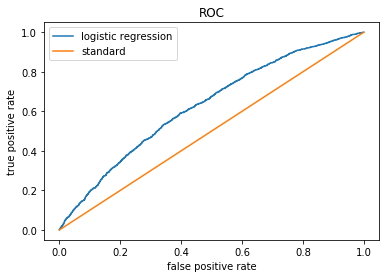

In [30]:
y_pred = regression.predict_proba(x_valid)
y_pred_up_prod = y_pred[:, 2]

y_true = (y_valid == 2).astype(int)

fpr_lr, tpr_lr, threshold = roc_curve(y_true, y_pred_up_prod)

plt.plot(fpr_lr, tpr_lr, label='logistic regression')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

### Use X1-X10, max, min, median, mean, trend, outlier of sentiment data to train random forest

In [42]:



parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
simple_model = GridSearchCV(RandomForestClassifier(n_estimators=200), 
                            param_grid=parameter_grid,
                            n_jobs=-1, cv=5)
simple_model.fit(x_train, y_train)


print(simple_model.best_params_)
print(classification_report(y_valid, simple_model.predict(x_valid)))
print(accuracy_score(y_valid, simple_model.predict(x_valid)))
print(log_loss(y_valid, simple_model.predict_proba(x_valid)))

{'max_depth': 16, 'min_samples_leaf': 64}
              precision    recall  f1-score   support

           0       0.41      0.21      0.28      1822
           1       0.50      0.67      0.57      1930
           2       0.42      0.48      0.45      1848

    accuracy                           0.46      5600
   macro avg       0.45      0.45      0.43      5600
weighted avg       0.45      0.46      0.44      5600

0.45732142857142855
1.0271909503169248


Text(0,0.5,'true positive rate')

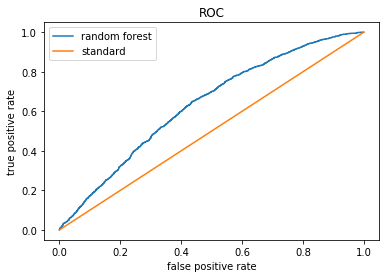

In [43]:
y_pred = simple_model.predict_proba(x_valid)
y_pred_up_prod = y_pred[:, 2]

y_true = (y_valid == 2).astype(int)

fpr_rf, tpr_rf, threshold = roc_curve(y_true, y_pred_up_prod)

plt.plot(fpr_rf, tpr_rf, label='random forest')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")


In [32]:
feature_importance = simple_model.best_estimator_.feature_importances_
feature_importance = pd.Series(feature_importance, x_train.columns)
feature_importance.sort_values().tail(20)

I6_min       0.015073
I2_min       0.015138
I3_median    0.015422
I8_max       0.018093
I3_max       0.018345
I2_max       0.018904
I5_min       0.021262
X1           0.022818
I4_max       0.023225
I6_max       0.025370
I8_min       0.031951
I4_min       0.034803
I1_min       0.037498
I7_min       0.037820
I1_max       0.045845
I10_min      0.065740
I10_max      0.070037
I9_min       0.074647
I7_max       0.103028
I9_max       0.115096
dtype: float64

In [33]:


# add the cross comparison features
# df_with_cross_comparison = add_cross_comparison(df)

# Predict probability of test data
output = simple_model.predict_proba(test)
#output = simple_model.predict_proba(df_with_cross_comparison)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("./output_data/lr_sentiment_rf.csv")


In [34]:
sentiment_importance = pd.Series(np.zeros(10), 
                                index=["I"+str(i) for i in range(1, 11)])
for i in range(1, 11):
    sentiment_label = "I{}".format(str(i))
    importance = feature_importance.loc[sentiment_label+"_max":sentiment_label+"_has_outlier"].sum()
    sentiment_importance[i-1] = importance

sentiment_importance.sort_values()

I2     0.042605
I5     0.044556
I3     0.051022
I6     0.053322
I8     0.062296
I4     0.068461
I1     0.093107
I10    0.148210
I7     0.156494
I9     0.203622
dtype: float64

#### Selecte Feature then train simple decision tree

In [35]:
from sklearn.tree import DecisionTreeClassifier

selected_feature = feature_importance.sort_values().tail(10).index

train_selected = train[selected_feature]

x_train_selected, x_valid_selected, y_train, y_valid = train_test_split(train_selected,
                                                      Y,  test_size=0.4)


parameter_grid = {"max_depth":[3, 4, 5], "min_samples_leaf":[32,64,128,256]}
decision_tree = GridSearchCV(RandomForestClassifier(n_estimators=200), 
                            param_grid=parameter_grid,
                            n_jobs=-1, cv=5)
decision_tree.fit(x_train, y_train)


print(decision_tree.best_params_)
print(classification_report(y_valid, decision_tree.predict(x_valid)))
print(accuracy_score(y_valid, decision_tree.predict(x_valid)))
print(log_loss(y_valid, decision_tree.predict_proba(x_valid)))

{'max_depth': 3, 'min_samples_leaf': 256}
              precision    recall  f1-score   support

           0       0.41      0.05      0.08      1795
           1       0.36      0.46      0.41      1978
           2       0.34      0.53      0.41      1827

    accuracy                           0.35      5600
   macro avg       0.37      0.34      0.30      5600
weighted avg       0.37      0.35      0.30      5600

0.3494642857142857
1.0978048138656622


### Model Comparison

Text(0,0.5,'true positive rate')

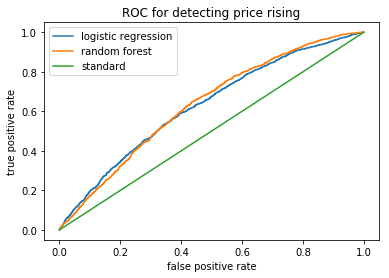

In [44]:
plt.plot(fpr_lr, tpr_lr, label='logistic regression')
plt.plot(fpr_rf, tpr_rf, label='random forest')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC for detecting price rising")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")


Text(0.5,1,'Confusion Matrix of Random Forest')

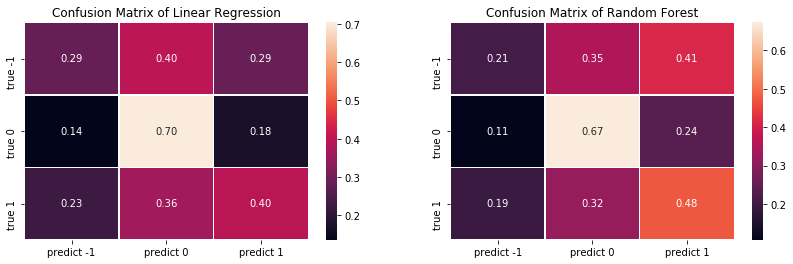

In [77]:
y_pred_lr = regression.predict(x_valid)
y_pred_rf = simple_model.predict(x_valid)

confu_mat_lr = confusion_matrix(y_valid, y_pred_lr)
confu_mat_rf = confusion_matrix(y_valid, y_pred_rf)

confu_mat_lr = confu_mat_lr/confu_mat_lr.sum(axis=1)
confu_mat_rf = confu_mat_rf/confu_mat_rf.sum(axis=1)

confu_mat_lr = pd.DataFrame(confu_mat_lr, 
                            index=['true -1', 'true 0', 'true 1'],
                           columns=['predict -1', 'predict 0', 'predict 1'])
confu_mat_rf = pd.DataFrame(confu_mat_rf, 
                            index=['true -1', 'true 0', 'true 1'],
                           columns=['predict -1', 'predict 0', 'predict 1'])


f=plt.figure(figsize=(14,4))

f.add_subplot(1,2,1)
ax = sns.heatmap(confu_mat_lr, annot=True, fmt=".2f",
           linewidth=0.5)
ax.set_title("Confusion Matrix of Linear Regression")

f.add_subplot(1,2,2)
ax = sns.heatmap(confu_mat_rf, annot=True, fmt=".2f",
           linewidth=0.5)
ax.set_title("Confusion Matrix of Random Forest")

In [69]:
a = confu_mat_lr / confu_mat_lr.sum(axis=1)
a

,negative,stable,positive
negative,0.285950,0.398446,0.287879
stable,0.136114,0.703627,0.175325
positive,0.227223,0.364249,0.395563


### Sentiment, X1-X5 and cross comparison

- Use X1-X5, 
- max, min, median, mean, trend of sentiment data, 
- cross comparison of X1-X5 (E.X. whether X1 > X2)

In [33]:
def add_cross_comparison(df):
    '''
    compare Xi with Xj, if Xi > Xj, then the value of new column "XiXj" is 1, else 0 
    '''
    for i in range(1, 6):
        for j in range(1, 6):
            col1, col2 = "X{}".format(str(i)), "X{}".format(str(j))
            df[col1+col2] = df[col1] > df[col2]
    return df


# Concatenate X1-X5 with sentiment feature
df = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)
# Add cross comparison feature
df = add_cross_comparison(df)

# split data into trainning data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(df, Y,  
                                                      test_size=0.2)


parameter_grid = {"C":[0.5, 0.6, 0.7, 0.8, 0.9, 1]}
simple_model = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                            n_jobs=-1)
simple_model.fit(x_train, y_train)


print(classification_report(y_valid, simple_model.predict(x_valid)))
print(accuracy_score(y_valid, simple_model.predict(x_valid)))
print(log_loss(y_valid, simple_model.predict_proba(x_valid)))

C:\Users\82091\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.41      0.31      0.36       627
           1       0.53      0.69      0.60       760
           2       0.46      0.40      0.43       713

    accuracy                           0.48      2100
   macro avg       0.47      0.47      0.46      2100
weighted avg       0.47      0.48      0.47      2100

0.48
1.0292395875960232


In [22]:
df.columns[df.columns.str.match('X.+')]

Index(['X1', 'X2', 'X3', 'X4', 'X5'], dtype='object')

### Pipeline

In [54]:
from sklearn.base import TransformerMixin, BaseEstimator


def transform(df):
    '''
    add max, min, median, mean, trend, if_has_outlier features to sentiment data
    '''
    sentiment = get_mean_max_min_median_trend_sentiment(df)
    # Concatenate X1-X5 with sentiment feature
    df = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)
    return df
    
    
class SimpleSentimentModel(TransformerMixin, BaseEstimator):
    '''
    model that only trained on sentiment data
    '''
    def __init__(self):
        self.model = None
    
    def transform(self, df):
        sentiment_col_mask = df.columns.str.match("I.+")
        sentiment_col_name = df.columns[sentiment_col_mask]
        sentiment_features = df[sentiment_col_name]
        return sentiment_features
    
    def fit(self, df, y):
        sentiment_features = self.transform(df)

        parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
        self.model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                    param_grid=parameter_grid,
                                    n_jobs=-1)
        self.model.fit(sentiment_features, y)
        
    def predict(self, df):
        sentiment_features = self.transform(df)
        simple_sentiment_output = self.model.predict_proba(sentiment_features)
        return simple_sentiment_output
    
    def fit_predict(self, df, y):
        sentiment_features = self.transform(df)

        parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
        self.model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                    param_grid=parameter_grid,
                                    n_jobs=-1)
        self.model.fit(sentiment_features, y)
        return self.model.predict_proba(sentiment_features)
        
    
    
    
class SimpleReturnModel(TransformerMixin, BaseEstimator):
    '''
    model that only trained on return data
    '''
    def __init__(self):
        self.model = None
    
    def transform(self, df):
        return_col_name = df.columns[df.columns.str.match('X.+')]
        return_features = df[return_col_name]
        return return_features
    
    def fit(self, df, y):
        return_features = self.transform(df)

        parameter_grid = {"C":[0.6, 0.7, 0.8, 0.9, 1]}
        self.model = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                                n_jobs=-1)
        self.model.fit(return_features, y)
        
    def predict(self, df):
        return_features = self.transform(df)
        simple_return_output = self.model.predict_proba(return_features)
        return simple_return_output
    
    def fit_predict(self, df, y):
        return_features = self.transform(df)

        parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
        self.model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                    param_grid=parameter_grid,
                                    n_jobs=-1)
        self.model.fit(return_features, y)
        return self.model.predict_proba(return_features)
    

        
        

    
def stacking1(df, y):
    '''
    stack sentiment model and return model (failed!!!!!! doesn't give good performance)
    '''
    df = transform(df)
    
    parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
    stack_model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                param_grid=parameter_grid,
                                n_jobs=-1)
    stack_model.fit(x_train, y_train)
    
    sentiment_model = SimpleSentimentModel()
    return_model = SimpleReturnModel()
    
    sentiment_output = sentiment_model.fit_predict(df, y)
    return_output = return_model.fit_predict(df, y)
    cross_features = sentiment_output*return_output
    
    second_layer = np.concatenate([return_output, sentiment_output, cross_features], axis=1)
    
    stack_model.fit(second_layer, y)
   
    def prediction_function(df):
        df = transformation(df)
        
        sentiment_output = sentiment_model.predict(df)
        return_output = return_model.predict(df)
        cross_features = sentiment_output*return_output
        
        second_layer = np.concatenate([return_output, sentiment_output, cross_features], axis=1)

        return stack_model.predict_proba(second_layer)
        
    return prediction_function, stack_model



x_train, x_valid, y_train, y_valid = train_test_split(df, Y,  
                                                      test_size=0.3)
    
prediction_pipeline, final_lr_model = stacking(x_train, y_train)


y_pred =  np.argmax(prediction_pipeline(x_valid), axis=1)
print(classification_report(y_valid, y_pred))
print(accuracy_score(y_valid,y_pred))
print(log_loss(y_valid, prediction_pipeline(x_valid)))
    
    


100%|██████████████████████████████████████████| 10/10 [00:28<00:00,  2.84s/it]


              precision    recall  f1-score   support

           0       0.41      0.39      0.40      1319
           1       0.55      0.56      0.55      1481
           2       0.43      0.43      0.43      1400

    accuracy                           0.46      4200
   macro avg       0.46      0.46      0.46      4200
weighted avg       0.46      0.46      0.46      4200

0.4645238095238095


100%|██████████████████████████████████████████| 10/10 [00:28<00:00,  2.85s/it]


1.1489834539733035


In [53]:
test_filename = './input_data/input_test_PkjtqdQ.csv'
test = pd.read_csv(test_filename).iloc[:, 1:]

output = prediction_pipeline(test)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("./output_data/lr_sentiment_stack_model.csv")

100%|██████████████████████████████████████████| 10/10 [00:33<00:00,  3.36s/it]


<a>Output submission file into the desired format</a>

In [13]:
# Read test file
test_filename = './input_data/input_test_PkjtqdQ.csv'
df = pd.read_csv(test_filename).iloc[:, 1:]

# Get the max, min, median, mean and trend of sentiment
sentiment = get_mean_max_min_median_trend_sentiment(df)
df = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)

# add the cross comparison features
# df_with_cross_comparison = add_cross_comparison(df)

# Predict probability of test data
output = simple_model.predict_proba(df)
#output = simple_model.predict_proba(df_with_cross_comparison)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("./output_data/lr_sentiment_decision_tree.csv")


100%|██████████████████████████████████████████| 10/10 [00:33<00:00,  3.35s/it]


NameError: name 'df_with_cross_comparison' is not defined